In [49]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import pandas as pd
import torch
import torch.nn as nn
import timm
from torch import optim
from utils.ProgressBar import ProgressBar
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from MachineLearning.ApartmentsDatasetPyTorch import ApartmentsDatasetPyTorch
from tqdm import tqdm
from DeepLearning.PricePredictionModel import PricePredictionModel

In [51]:
params = {
    "data_dir" : "../processed_data/data_tiny.csv",
    "images_dir" : '../processed_data/images_tiny',
    "img_input_size" : 256,
    "batch_size" : 32, # because we have a lot of columns
    "shuffle" : False,
    
    "inception_model_output_size" : 1024,
    "tabular_ffnn_output_size" : 256,
    "learning_rate" : 0.5e-3,
    "weight_decay" : 1e-4
}

In [58]:
gpu = torch.device("mps:0")

transform = transforms.Compose([
    transforms.Resize((params["img_input_size"], params["img_input_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

dataset = ApartmentsDatasetPyTorch(
    device = gpu,
    data_dir = params["data_dir"],
    images_dir = params["images_dir"], 
    transform = transform
)
print("Tabular Size", len(dataset.df))
model = PricePredictionModel(
    dataset.tabular_data_size(), 
    params
)
model = model.to(gpu)

Tabular Size 100
Inception output size 256
Tabular output size 64
Regression input size 320


# Training

In [60]:
# Assuming 'dataset' is your full dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
num_epochs = 20
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
num_GPU = 1

train_loader = DataLoader(
    train_dataset,
    batch_size=params["batch_size"], 
    shuffle=params["shuffle"]
)
val_loader = DataLoader(
    val_dataset,
    batch_size=params["batch_size"],
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=params["batch_size"], 
    shuffle=False
)

# Initialize lists to track losses
train_losses = []
val_losses = []

optimizer = optim.Adam(
    model.parameters(), 
    lr=params["learning_rate"],
    weight_decay = params["weight_decay"]
)
criterion = torch.nn.MSELoss()
criterion_abs = torch.nn.L1Loss()

print("Starting training...")
# Training loop with progress bar
for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    running_loss = 0.0
    l1_losses = []
    for data in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
        images, datas, prices = data
        optimizer.zero_grad()
        outputs = model(images, datas)
        prices_viewed = prices.view(-1, 1).float()
        loss = criterion(outputs, prices_viewed)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for data in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
            images, datas, prices = data
            outputs = model(images, datas)  # Forward pass
            prices_viewed = prices.view(-1, 1).float()
            loss = criterion(outputs, prices_viewed)  # Compute loss
            val_loss += loss.item()  # Accumulate the loss
            l1_losses.append(criterion_abs(outputs, prices_viewed))
        
    val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
    l1_mean_loss = sum(l1_losses) / len(l1_losses)
    # Print epoch's summary
    print(f'Epoch {epoch+1}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, L1: {l1_mean_loss}')


Starting training...


Epoch 1/20 - Validation: 100%|████████████████████| 9/9 [00:05<00:00,  1.52it/s]


Epoch 1, Training Loss: 106051482755.28206, Validation Loss: 105485225528.88889, L1: 268338.1875


Epoch 2/20 - Validation: 100%|████████████████████| 9/9 [00:05<00:00,  1.52it/s]


Epoch 2, Training Loss: 31131177905.23077, Validation Loss: 46205013333.333336, L1: 149976.5625


Epoch 3/20 - Validation: 100%|████████████████████| 9/9 [00:05<00:00,  1.52it/s]


Epoch 3, Training Loss: 19918299661.128204, Validation Loss: 39071389155.55556, L1: 130259.5546875


Epoch 4/20 - Validation: 100%|████████████████████| 9/9 [00:08<00:00,  1.00it/s]


Epoch 4, Training Loss: 14003113314.461538, Validation Loss: 39020309048.888885, L1: 131020.9296875


Epoch 5/20 - Validation: 100%|████████████████████| 9/9 [00:06<00:00,  1.48it/s]


Epoch 5, Training Loss: 11107767624.205128, Validation Loss: 35198589944.888885, L1: 128354.234375


Epoch 6/20 - Validation: 100%|████████████████████| 9/9 [00:05<00:00,  1.50it/s]


Epoch 6, Training Loss: 9199046038.97436, Validation Loss: 32833063736.88889, L1: 122769.6640625


Epoch 7/20 - Validation: 100%|████████████████████| 9/9 [00:05<00:00,  1.52it/s]


Epoch 7, Training Loss: 8200700176.410256, Validation Loss: 39707315939.55556, L1: 131249.5625


Epoch 8/20 - Validation: 100%|████████████████████| 9/9 [00:05<00:00,  1.56it/s]


Epoch 8, Training Loss: 7731354820.923077, Validation Loss: 31462746083.555557, L1: 123260.4453125


Epoch 9/20 - Validation: 100%|████████████████████| 9/9 [00:05<00:00,  1.56it/s]


Epoch 9, Training Loss: 6655196594.871795, Validation Loss: 41084746638.22222, L1: 133527.171875


Epoch 10/20 - Validation: 100%|███████████████████| 9/9 [00:05<00:00,  1.57it/s]


Epoch 10, Training Loss: 6039130651.076923, Validation Loss: 45429153109.333336, L1: 141547.796875


Epoch 11/20 - Validation: 100%|███████████████████| 9/9 [00:05<00:00,  1.50it/s]


Epoch 11, Training Loss: 6450509840.410256, Validation Loss: 39898444088.888885, L1: 129929.5


Epoch 12/20 - Validation: 100%|███████████████████| 9/9 [00:05<00:00,  1.56it/s]


Epoch 12, Training Loss: 5876242116.923077, Validation Loss: 38437198321.77778, L1: 132415.171875


Epoch 13/20 - Validation: 100%|███████████████████| 9/9 [00:05<00:00,  1.54it/s]


Epoch 13, Training Loss: 6026132867.282051, Validation Loss: 40055887416.888885, L1: 135117.421875


Epoch 14/20 - Validation: 100%|███████████████████| 9/9 [00:05<00:00,  1.59it/s]


Epoch 14, Training Loss: 6101026691.282051, Validation Loss: 48624377514.666664, L1: 139407.390625


Epoch 15/20 - Validation: 100%|███████████████████| 9/9 [00:05<00:00,  1.60it/s]


Epoch 15, Training Loss: 6408339278.769231, Validation Loss: 43938466929.77778, L1: 135217.640625


Epoch 16/20 - Validation: 100%|███████████████████| 9/9 [00:05<00:00,  1.59it/s]


Epoch 16, Training Loss: 5346343683.282051, Validation Loss: 49760128568.888885, L1: 141616.359375


Epoch 17/20 - Validation: 100%|███████████████████| 9/9 [00:05<00:00,  1.59it/s]


Epoch 17, Training Loss: 5523301179.076923, Validation Loss: 39711028252.44444, L1: 132884.265625


Epoch 18/20 - Validation: 100%|███████████████████| 9/9 [00:05<00:00,  1.55it/s]


Epoch 18, Training Loss: 5555668617.846154, Validation Loss: 48061347612.44444, L1: 140581.75


Epoch 19/20 - Validation: 100%|███████████████████| 9/9 [00:05<00:00,  1.53it/s]


Epoch 19, Training Loss: 5363083408.410256, Validation Loss: 40857712412.44444, L1: 136031.890625


Epoch 20/20 - Validation: 100%|███████████████████| 9/9 [00:05<00:00,  1.51it/s]

Epoch 20, Training Loss: 5258679309.128205, Validation Loss: 38429532017.77778, L1: 130170.5


In [61]:
# torch.save(model, "models/model_v5.pth")

In [62]:
# !conda install --yes pytorch torchvision -c pytorch

In [63]:
import matplotlib.pyplot as plt

train_losses
val_losses

[105485225528.88889,
 46205013333.333336,
 39071389155.55556,
 39020309048.888885,
 35198589944.888885,
 32833063736.88889,
 39707315939.55556,
 31462746083.555557,
 41084746638.22222,
 45429153109.333336,
 39898444088.888885,
 38437198321.77778,
 40055887416.888885,
 48624377514.666664,
 43938466929.77778,
 49760128568.888885,
 39711028252.44444,
 48061347612.44444,
 40857712412.44444,
 38429532017.77778]

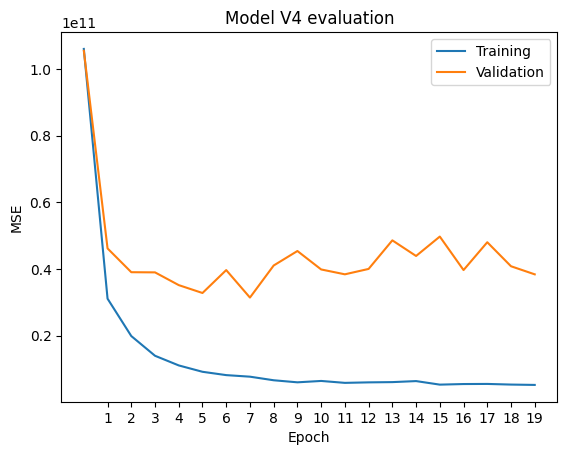

<Figure size 640x480 with 0 Axes>

In [65]:
plt.title("Model V4 evaluation")
plt.plot(train_losses, label = 'Training')
plt.plot(val_losses, label = 'Validation')
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.xticks(range(1, 20))
plt.legend()
plt.show()
plt.savefig('model_v4_epochs.png')